In [2]:
import multiprocessing as mp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

RS = 47
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [3]:
df_lab1 = pd.read_csv('../Lab2/processed_standardized.csv')

print(df_lab1.shape)
df_lab1.head(5)

(122410, 91)


,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,1.415828,-1.400576,-1.405702,-1.30641,-0.354764,0.664386,0.695301,-1.836777,-1.709542,-0.516186,...,-1.035461,-0.886648,-0.889569,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,0
1,1.067531,-1.400576,-1.405702,-1.30641,-0.354764,0.664386,0.695301,0.502008,0.008909,-0.819351,...,-1.035461,-0.886648,0.203841,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,0
2,-0.034094,-1.400576,-1.405702,-1.30641,-0.354764,-0.159544,-0.019401,-0.117770,-0.563908,-0.805977,...,-1.035461,-0.886648,0.203841,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,0
3,-0.401302,-1.400576,-1.405702,-1.30641,-0.354764,-0.159544,-0.019401,-0.117770,-0.563908,-0.805977,...,-1.035461,-0.886648,-0.889569,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,0
4,1.415277,-1.191823,-1.405702,-1.30641,-0.354764,0.664386,0.695301,-0.714160,-1.709542,0.763351,...,-1.035461,-0.886648,-0.889569,-0.687185,-0.137694,-0.210881,-0.812929,-0.163356,-0.156855,0


In [4]:
X = df_lab1.drop('round_winner', axis=1)
y = df_lab1['round_winner']

In [5]:
y.value_counts()

1    62406
0    60004
Name: round_winner, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=RS)

print(f'X_train={X_train.shape}, y_train={y_train.shape}\nX_test={X_test.shape}, y_test={y_test.shape}')

X_train=(97928, 90), y_train=(97928,)
X_test=(24482, 90), y_test=(24482,)


In [7]:
n_features = X_train.shape[1]

In [8]:
n_features

90

In [13]:
def plot_metric(history: keras.callbacks.History, metric: str, k: int = 5) -> None:
    assert metric in ['accuracy', 'loss'], "Wrong type of metric. Just use 'accuracy' or 'loss'"
    
    train_metrics = history.history[metric]
    val_metrics = history.history[f'val_{metric}']
    epochs = range(1, len(train_metrics) + 1)
    
    plt.plot(epochs, train_metrics, '-o', markersize=3, label=f"Training {metric}")
    plt.plot(epochs, val_metrics, label=f"Validation {metric}")
    
    plt.xticks([1] + [i for i in epochs if i % k == 0])
    
    plt.title(f'Training and validation {metric}')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()

# FNN

In [197]:
checkpoint = ModelCheckpoint("checkpoints/best_model_FNN.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='min', save_freq='epoch')

model = keras.Sequential([
    layers.Dense(128, kernel_initializer='he_normal', input_shape=(n_features,), kernel_constraint=MaxNorm(3)),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(512, kernel_initializer='he_normal', kernel_constraint=MaxNorm(3)),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(512, kernel_initializer='he_normal', kernel_constraint=MaxNorm(3)),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, kernel_initializer='he_normal', kernel_constraint=MaxNorm(3)),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, kernel_initializer='he_normal', kernel_constraint=MaxNorm(3)),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_137 (Dense)           (None, 128)               11648     
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 batch_normalization_61 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_138 (Dense)           (None, 512)               66048     
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                     

In [198]:
history = model.fit(X_train, y_train, 
                    epochs=80, batch_size=256, validation_split=0.25, shuffle=True,
                    callbacks=[checkpoint], 
                    verbose=2)

Epoch 1/80


/home/henitsoi/kpi/data_analysis/venv/lib/python3.10/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



Epoch 1: val_loss improved from inf to 0.45663, saving model to checkpoints/best_model_FNN.hdf5
1148/1148 - 15s - loss: 0.5170 - accuracy: 0.7231 - val_loss: 0.4566 - val_accuracy: 0.7472 - 15s/epoch - 13ms/step
Epoch 2/80

Epoch 2: val_loss improved from 0.45663 to 0.45308, saving model to checkpoints/best_model_FNN.hdf5
1148/1148 - 11s - loss: 0.4708 - accuracy: 0.7436 - val_loss: 0.4531 - val_accuracy: 0.7530 - 11s/epoch - 10ms/step
Epoch 3/80

Epoch 3: val_loss did not improve from 0.45308
1148/1148 - 9s - loss: 0.4613 - accuracy: 0.7501 - val_loss: 0.4566 - val_accuracy: 0.7415 - 9s/epoch - 8ms/step
Epoch 4/80

Epoch 4: val_loss improved from 0.45308 to 0.44604, saving model to checkpoints/best_model_FNN.hdf5
1148/1148 - 7s - loss: 0.4565 - accuracy: 0.7517 - val_loss: 0.4460 - val_accuracy: 0.7606 - 7s/epoch - 6ms/step
Epoch 5/80

Epoch 5: val_loss improved from 0.44604 to 0.44251, saving model to checkpoints/best_model_FNN.hdf5
1148/1148 - 13s - loss: 0.4505 - accuracy: 0.7585 

1148/1148 - 6s - loss: 0.3483 - accuracy: 0.8303 - val_loss: 0.3754 - val_accuracy: 0.8185 - 6s/epoch - 5ms/step
Epoch 41/80

Epoch 41: val_loss did not improve from 0.37537
1148/1148 - 6s - loss: 0.3489 - accuracy: 0.8320 - val_loss: 0.3784 - val_accuracy: 0.8184 - 6s/epoch - 5ms/step
Epoch 42/80

Epoch 42: val_loss did not improve from 0.37537
1148/1148 - 6s - loss: 0.3446 - accuracy: 0.8333 - val_loss: 0.3772 - val_accuracy: 0.8163 - 6s/epoch - 5ms/step
Epoch 43/80

Epoch 43: val_loss improved from 0.37537 to 0.37327, saving model to checkpoints/best_model_FNN.hdf5
1148/1148 - 6s - loss: 0.3458 - accuracy: 0.8322 - val_loss: 0.3733 - val_accuracy: 0.8186 - 6s/epoch - 5ms/step
Epoch 44/80

Epoch 44: val_loss improved from 0.37327 to 0.37125, saving model to checkpoints/best_model_FNN.hdf5
1148/1148 - 6s - loss: 0.3454 - accuracy: 0.8341 - val_loss: 0.3712 - val_accuracy: 0.8181 - 6s/epoch - 5ms/step
Epoch 45/80

Epoch 45: val_loss improved from 0.37125 to 0.37051, saving model to che

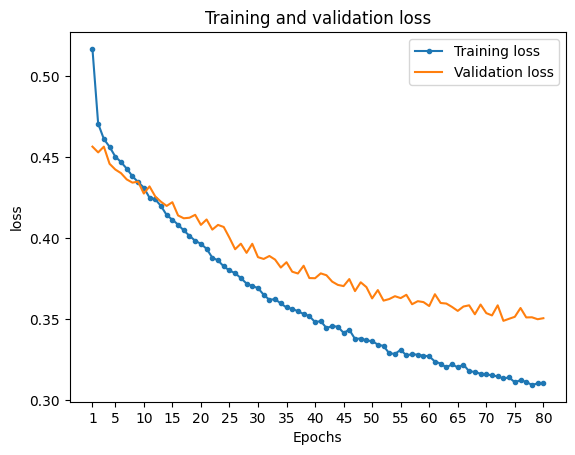

In [199]:
plot_metric(history, 'loss')

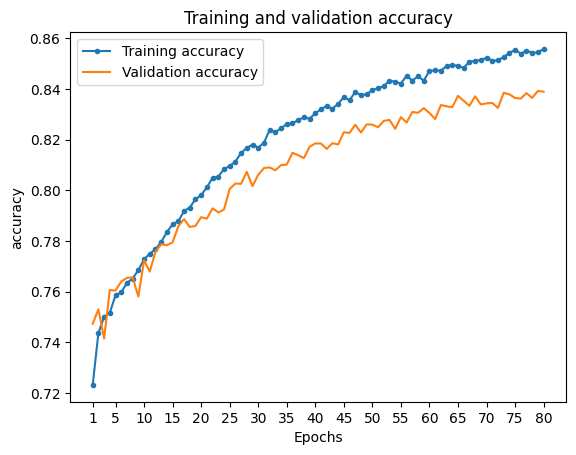

In [200]:
plot_metric(history, 'accuracy')

In [201]:
model = keras.models.load_model('checkpoints/best_model_FNN.hdf5')

loss, acc = model.evaluate(X_test, y_test, verbose=0) 
print(f'Test accuracy: {acc}')

Test accuracy: 0.8399232029914856


In [202]:
predict_FNN = (model.predict(X_test, verbose=0) > 0.5).astype("int32")
print(classification_report(y_test, predict_FNN))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84     12115
           1       0.85      0.84      0.84     12367

    accuracy                           0.84     24482
   macro avg       0.84      0.84      0.84     24482
weighted avg       0.84      0.84      0.84     24482



In [203]:
confusion_matrix(y_test, predict_FNN)

array([[10229,  1886],
       [ 2033, 10334]])

# CNN

## https://www.kaggle.com/datasets/slothkong/10-monkey-species

In [587]:
info = pd.read_csv('monkey_labels.txt')
info

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [4]:
train_ds, val_ds = image_dataset_from_directory(
    'training/training', label_mode='categorical', crop_to_aspect_ratio=True, 
    subset='both', validation_split=0.2, seed=RS)
test_ds = image_dataset_from_directory(
    'validation/validation', label_mode='categorical', crop_to_aspect_ratio=True, seed=RS)

Found 1097 files belonging to 10 classes.
Using 878 files for training.
Using 219 files for validation.
Found 272 files belonging to 10 classes.


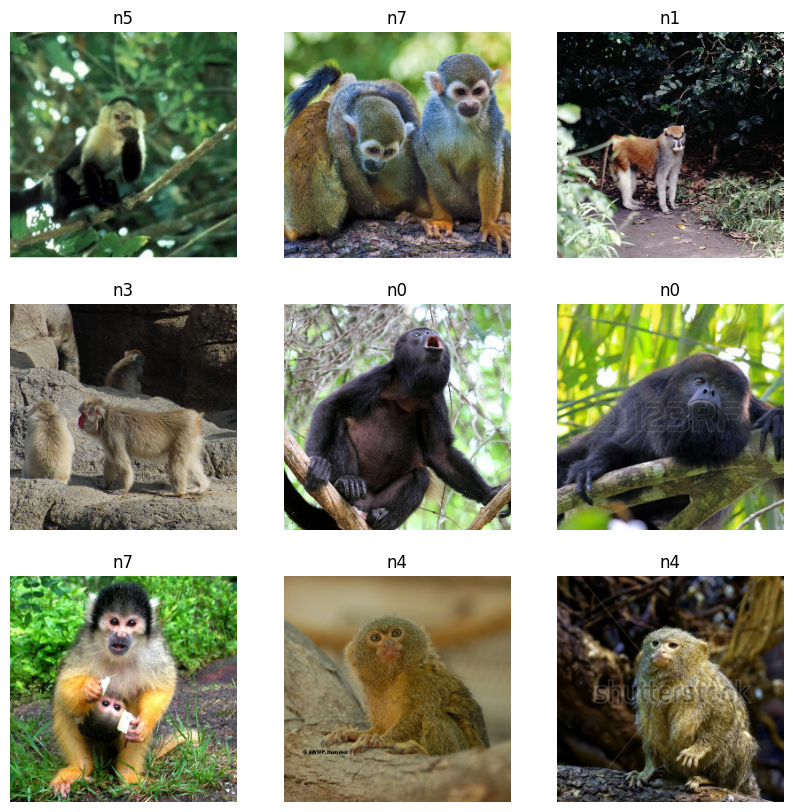

In [575]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[np.argmax(labels.numpy(), axis=1)[i]])
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
checkpoint_loss = ModelCheckpoint("checkpoints/best_model_CNN_loss.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='min', save_freq='epoch')
checkpoint_acc = ModelCheckpoint("checkpoints/best_model_CNN_acc.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', save_freq='epoch')

def CNN(input_shape: tuple, N_classes: int):
    model = keras.Sequential()
    
    model.add(layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape)),
    model.add(layers.RandomRotation(0.2)),
    model.add(layers.RandomTranslation(height_factor=0.2, width_factor=0.2)),
    model.add(layers.RandomZoom(0.2)),
    model.add(layers.Rescaling(1. / 255)),
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    model.add(layers.GlobalAvgPool2D())
    
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(N_classes, activation='softmax'))
    return model

model = CNN(input_shape=(256, 256, 3), N_classes=10)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_6 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_6 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_translation_6 (Rando  (None, 256, 256, 3)      0         
 mTranslation)                                                   
                                                                 
 random_zoom_6 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 254, 254, 32)     

In [43]:
history = model.fit(train_ds, 
                    epochs=150, batch_size=64, validation_data=val_ds, shuffle=True,
                    callbacks=[checkpoint_loss, checkpoint_acc], 
                    verbose=2)

Epoch 1/150


2022-11-21 17:33:35.635166: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 2.29319, saving model to checkpoints/best_model_CNN_loss.hdf5

Epoch 1: val_accuracy improved from -inf to 0.12329, saving model to checkpoints/best_model_CNN_acc.hdf5
28/28 - 8s - loss: 2.6200 - accuracy: 0.2175 - val_loss: 2.2932 - val_accuracy: 0.1233 - 8s/epoch - 297ms/step
Epoch 2/150

Epoch 2: val_loss did not improve from 2.29319

Epoch 2: val_accuracy did not improve from 0.12329
28/28 - 3s - loss: 2.2454 - accuracy: 0.3052 - val_loss: 2.3057 - val_accuracy: 0.1187 - 3s/epoch - 115ms/step
Epoch 3/150

Epoch 3: val_loss did not improve from 2.29319

Epoch 3: val_accuracy did not improve from 0.12329
28/28 - 3s - loss: 2.0371 - accuracy: 0.3428 - val_loss: 2.3433 - val_accuracy: 0.1096 - 3s/epoch - 117ms/step
Epoch 4/150

Epoch 4: val_loss did not improve from 2.29319

Epoch 4: val_accuracy did not improve from 0.12329
28/28 - 3s - loss: 1.9338 - accuracy: 0.3781 - val_loss: 2.3894 - val_accuracy: 0.1050 - 3s/epoch - 116ms/step
Epoch 5/150


Epoch 34/150

Epoch 34: val_loss did not improve from 1.73877

Epoch 34: val_accuracy did not improve from 0.51598
28/28 - 3s - loss: 1.0365 - accuracy: 0.6458 - val_loss: 4.0561 - val_accuracy: 0.2648 - 3s/epoch - 115ms/step
Epoch 35/150

Epoch 35: val_loss improved from 1.73877 to 1.67879, saving model to checkpoints/best_model_CNN_loss.hdf5

Epoch 35: val_accuracy did not improve from 0.51598
28/28 - 3s - loss: 0.9503 - accuracy: 0.6708 - val_loss: 1.6788 - val_accuracy: 0.4566 - 3s/epoch - 118ms/step
Epoch 36/150

Epoch 36: val_loss improved from 1.67879 to 1.43230, saving model to checkpoints/best_model_CNN_loss.hdf5

Epoch 36: val_accuracy improved from 0.51598 to 0.52511, saving model to checkpoints/best_model_CNN_acc.hdf5
28/28 - 3s - loss: 0.9487 - accuracy: 0.6538 - val_loss: 1.4323 - val_accuracy: 0.5251 - 3s/epoch - 119ms/step
Epoch 37/150

Epoch 37: val_loss did not improve from 1.43230

Epoch 37: val_accuracy did not improve from 0.52511
28/28 - 3s - loss: 0.9433 - accura


Epoch 69: val_accuracy did not improve from 0.55251
28/28 - 3s - loss: 0.6237 - accuracy: 0.7756 - val_loss: 3.5641 - val_accuracy: 0.2968 - 3s/epoch - 116ms/step
Epoch 70/150

Epoch 70: val_loss did not improve from 1.43230

Epoch 70: val_accuracy did not improve from 0.55251
28/28 - 3s - loss: 0.5552 - accuracy: 0.8064 - val_loss: 2.4643 - val_accuracy: 0.4247 - 3s/epoch - 116ms/step
Epoch 71/150

Epoch 71: val_loss did not improve from 1.43230

Epoch 71: val_accuracy did not improve from 0.55251
28/28 - 3s - loss: 0.5860 - accuracy: 0.7916 - val_loss: 2.5983 - val_accuracy: 0.4018 - 3s/epoch - 115ms/step
Epoch 72/150

Epoch 72: val_loss did not improve from 1.43230

Epoch 72: val_accuracy did not improve from 0.55251
28/28 - 3s - loss: 0.5537 - accuracy: 0.8212 - val_loss: 2.1170 - val_accuracy: 0.4795 - 3s/epoch - 115ms/step
Epoch 73/150

Epoch 73: val_loss did not improve from 1.43230

Epoch 73: val_accuracy did not improve from 0.55251
28/28 - 3s - loss: 0.5646 - accuracy: 0.801

Epoch 105/150

Epoch 105: val_loss did not improve from 1.34407

Epoch 105: val_accuracy improved from 0.64384 to 0.64840, saving model to checkpoints/best_model_CNN_acc.hdf5
28/28 - 3s - loss: 0.4261 - accuracy: 0.8462 - val_loss: 1.4282 - val_accuracy: 0.6484 - 3s/epoch - 119ms/step
Epoch 106/150

Epoch 106: val_loss did not improve from 1.34407

Epoch 106: val_accuracy did not improve from 0.64840
28/28 - 3s - loss: 0.4168 - accuracy: 0.8554 - val_loss: 1.7800 - val_accuracy: 0.5068 - 3s/epoch - 115ms/step
Epoch 107/150

Epoch 107: val_loss did not improve from 1.34407

Epoch 107: val_accuracy did not improve from 0.64840
28/28 - 3s - loss: 0.3983 - accuracy: 0.8679 - val_loss: 1.6185 - val_accuracy: 0.5845 - 3s/epoch - 116ms/step
Epoch 108/150

Epoch 108: val_loss did not improve from 1.34407

Epoch 108: val_accuracy did not improve from 0.64840
28/28 - 3s - loss: 0.4630 - accuracy: 0.8280 - val_loss: 1.7055 - val_accuracy: 0.5616 - 3s/epoch - 116ms/step
Epoch 109/150

Epoch 109: v

Epoch 140/150

Epoch 140: val_loss did not improve from 1.33783

Epoch 140: val_accuracy did not improve from 0.65753
28/28 - 3s - loss: 0.2781 - accuracy: 0.8998 - val_loss: 2.0526 - val_accuracy: 0.5708 - 3s/epoch - 116ms/step
Epoch 141/150

Epoch 141: val_loss did not improve from 1.33783

Epoch 141: val_accuracy did not improve from 0.65753
28/28 - 3s - loss: 0.2918 - accuracy: 0.8964 - val_loss: 1.8589 - val_accuracy: 0.5525 - 3s/epoch - 116ms/step
Epoch 142/150

Epoch 142: val_loss did not improve from 1.33783

Epoch 142: val_accuracy did not improve from 0.65753
28/28 - 3s - loss: 0.2949 - accuracy: 0.8998 - val_loss: 2.2344 - val_accuracy: 0.5068 - 3s/epoch - 115ms/step
Epoch 143/150

Epoch 143: val_loss did not improve from 1.33783

Epoch 143: val_accuracy did not improve from 0.65753
28/28 - 3s - loss: 0.2947 - accuracy: 0.9066 - val_loss: 1.6370 - val_accuracy: 0.5799 - 3s/epoch - 115ms/step
Epoch 144/150

Epoch 144: val_loss did not improve from 1.33783

Epoch 144: val_accu

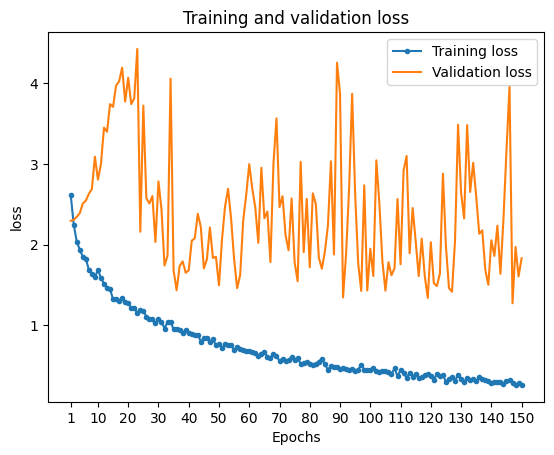

In [44]:
plot_metric(history, 'loss', k=10)

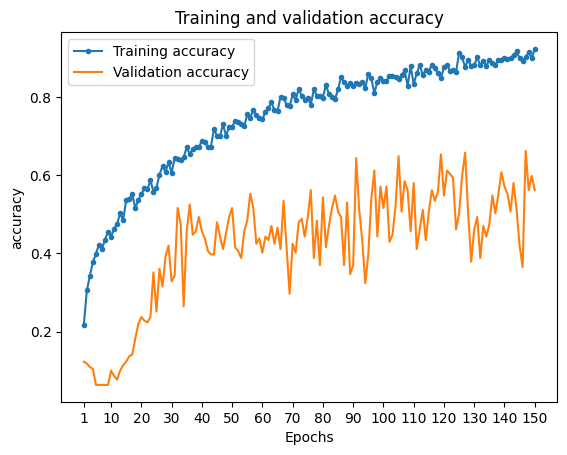

In [45]:
plot_metric(history, 'accuracy', k=10)

In [46]:
model = keras.models.load_model('checkpoints/best_model_CNN_acc.hdf5')

loss, acc = model.evaluate(test_ds, verbose=0) 
print(f'Test accuracy: {acc}')

Test accuracy: 0.6507353186607361


In [48]:
y_test = []
for _, l in test_ds:
    y_test.extend(np.argmax(l.numpy(), axis=1))
len(y_test)

272

In [49]:
predict_CNN = np.argmax(model.predict(test_ds, verbose=0), axis=1)
print(classification_report(y_test, predict_CNN))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68        26
           1       0.31      0.54      0.39        28
           2       0.92      0.81      0.86        27
           3       0.77      0.80      0.79        30
           4       0.61      0.54      0.57        26
           5       0.86      0.68      0.76        28
           6       0.69      0.69      0.69        26
           7       0.55      0.39      0.46        28
           8       0.68      0.78      0.72        27
           9       0.73      0.62      0.67        26

    accuracy                           0.65       272
   macro avg       0.68      0.65      0.66       272
weighted avg       0.68      0.65      0.66       272



In [50]:
confusion_matrix(y_test, predict_CNN)

array([[17,  1,  0,  0,  1,  2,  0,  2,  0,  3],
       [ 0, 15,  0,  3,  1,  0,  0,  6,  3,  0],
       [ 0,  2, 22,  1,  1,  0,  1,  0,  0,  0],
       [ 0,  1,  2, 24,  0,  1,  1,  0,  1,  0],
       [ 1,  4,  0,  1, 14,  0,  2,  0,  4,  0],
       [ 2,  2,  0,  0,  1, 19,  2,  1,  0,  1],
       [ 0,  7,  0,  1,  0,  0, 18,  0,  0,  0],
       [ 0, 11,  0,  0,  2,  0,  1, 11,  1,  2],
       [ 0,  4,  0,  0,  1,  0,  1,  0, 21,  0],
       [ 4,  2,  0,  1,  2,  0,  0,  0,  1, 16]])

# RNN

In [225]:
df_lab2 = pd.read_csv('../Lab2/processed_fake_job_postings.csv')

print(df_lab2.shape)
df_lab2.head(5)

(17581, 2)


,fraudulent,text
0,0,marketing intern ny new york marketing created...
1,0,customer service cloud video production nz auc...
2,0,commissioning machinery assistant cma ia wever...
3,0,account executive washington dc dc washington ...
4,0,bill review manager fl fort worth spotsource s...


In [306]:
X_train, X_test, y_train, y_test = train_test_split(df_lab2['text'], df_lab2['fraudulent'], shuffle=True, test_size=0.2, random_state=RS)

print(f'X_train={X_train.shape}, y_train={y_train.shape}\nX_test={X_test.shape}, y_test={y_test.shape}')

X_train=(14064,), y_train=(14064,)
X_test=(3517,), y_test=(3517,)


In [307]:
tokenizer = Tokenizer(num_words=5_000)
tokenizer.fit_on_texts(X_train)

In [308]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [309]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

132931


In [310]:
maxlen=1000

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [311]:
print(X_train[0, :])

[ 186   63   19   50  334  209  160   63    1  465  209   69 3766  618
  209   43  479  618   90   56  215   73   20  143  209  618  308  538
 2548  373 1102  432   15    1 1966  492   69  355 1329    2  143    9
 1734  395 1159   27   15    1   69  355 1329    2 2734  695 1320 2040
 2922 1013  695  403  123   95   22 3447  522  472   10 1233   15 1124
  659  132    9  258  206  230 1213  183 2106   63   27  600  210   15
  347   16  232  385   15 4147  390  333  217 1900 3795  688 4423    9
   13 4377   10  127  215 4185  460  311  389 1658  962   27   22  634
 1794 2075  230  485   30 3882  392 1157  275   24  393   64 3882  414
  460   27  634  230  206  275  837   57    2   69  489   15  629  890
  392   32  377  355  131  221  243   30  689   15   27   35   85   78
 1273   70 2756   63   27  842   48  129  126  536   17  147   12   15
 2610  225  752  212  261 1267  161  459 2786  760    2  459  524   54
 1476   71 2364   32  679   51   69  306  553   19    1 1267   71    1
  706 

In [313]:
X_train.shape[1]

1000

In [353]:
checkpoint = ModelCheckpoint("checkpoints/best_model_RNN.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='min', save_freq='epoch')

model = tf.keras.Sequential([
    layers.Embedding(
        input_dim=vocab_size,
        output_dim=64,
        input_shape=(X_train.shape[1],), mask_zero=True),
    layers.LSTM(64, activation='tanh', dropout=0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 1000, 64)          8507584   
                                                                 
 lstm_16 (LSTM)              (None, 64)                33024     
                                                                 
 dense_187 (Dense)           (None, 1)                 65        
                                                                 
Total params: 8,540,673
Trainable params: 8,540,673
Non-trainable params: 0
_________________________________________________________________


In [354]:
history = model.fit(X_train, y_train, 
                    epochs=10, batch_size=64, 
                    validation_split=0.25,
                    shuffle=True,
                    callbacks=[checkpoint], 
                    verbose=2)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.14746, saving model to checkpoints/best_model_RNN.hdf5
165/165 - 16s - loss: 0.2212 - accuracy: 0.9477 - val_loss: 0.1475 - val_accuracy: 0.9596 - 16s/epoch - 100ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.14746 to 0.11151, saving model to checkpoints/best_model_RNN.hdf5
165/165 - 10s - loss: 0.1038 - accuracy: 0.9675 - val_loss: 0.1115 - val_accuracy: 0.9718 - 10s/epoch - 60ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.11151 to 0.08941, saving model to checkpoints/best_model_RNN.hdf5
165/165 - 8s - loss: 0.0608 - accuracy: 0.9820 - val_loss: 0.0894 - val_accuracy: 0.9770 - 8s/epoch - 49ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.08941
165/165 - 6s - loss: 0.0423 - accuracy: 0.9873 - val_loss: 0.1067 - val_accuracy: 0.9653 - 6s/epoch - 38ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.08941
165/165 - 5s - loss: 0.0283 - accuracy: 0.9920 - val_loss: 0.0987 - val_accuracy: 0.9716 - 5s/epo

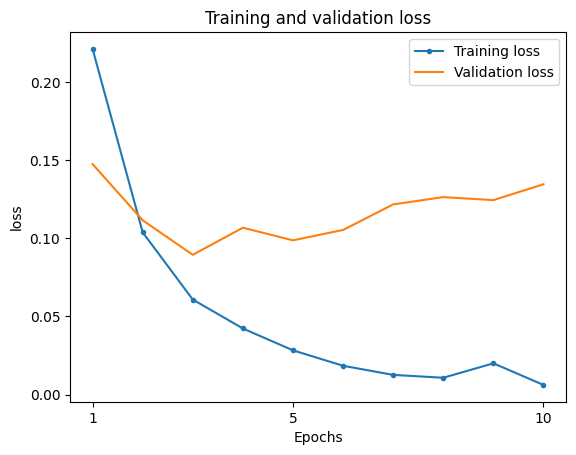

In [355]:
plot_metric(history, 'loss')

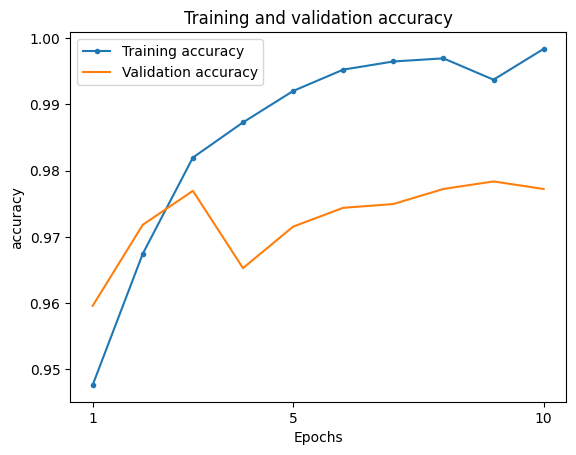

In [356]:
plot_metric(history, 'accuracy')

In [359]:
model = keras.models.load_model('checkpoints/best_model_RNN.hdf5')

loss, acc = model.evaluate(X_test, y_test, verbose=0) 
print(f'Test accuracy: {acc}')

Test accuracy: 0.9724196791648865


In [360]:
predict_RNN = (model.predict(X_test, verbose=0) > 0.5).astype("int32")
print(classification_report(y_test, predict_RNN))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3335
           1       0.88      0.54      0.67       182

    accuracy                           0.97      3517
   macro avg       0.93      0.77      0.83      3517
weighted avg       0.97      0.97      0.97      3517



In [361]:
confusion_matrix(y_test, predict_RNN)

array([[3322,   13],
       [  84,   98]])